In [1]:
from src.data_preparer import S_to_A, S_to_B, incidence_to_hyperedges, prepare_node_hyperneighbors_map
from sklearn.model_selection import train_test_split
import xgboost as xgb


ModuleNotFoundError: No module named 'src'

In [163]:
inputfilePath = "/home2/e1-313-15477/ego-Facebook.edges"
edgelist=[]
f = open(inputfilePath, "r")
for line in f:
    a = int(line.split(' ')[0].strip())  # \t
    b = int(line.split(' ')[1].strip())
    if (a!= b):
        edge=[a,b]
        edgelist.append(edge)
f.close()
graph = nx.Graph()
graph.add_edges_from(edgelist)
adj=nx.adj_matrix(graph)
A=adj
test_pairs = list(zip(*triu(A).nonzero()))
print(len(test_pairs))
G = nx.from_scipy_sparse_matrix(A)
S=nx.incidence_matrix(G)
times=[]
for i in range(2519):
    times.append(0)

2519


In [175]:
weighted_lp_data = prepare_lp_data(S, True, times, lp_data_params['rho'],lp_data_params['neg_factor'],lp_data_params['neg_mode'] )
weighted_linkpred_scores_df = get_linkpred_scores(weighted_lp_data, True, linkpred_indices)
unweighted_linkpred_scores_df = get_linkpred_scores(weighted_lp_data, False, linkpred_indices)
unweighted_linkpred_cols = list(unweighted_linkpred_scores_df.columns)
cols_map = {c: 'w_{}'.format(c) for c in unweighted_linkpred_cols}
weighted_linkpred_scores_df = weighted_linkpred_scores_df.rename(columns=cols_map)
weighted_linkpred_cols = list(weighted_linkpred_scores_df.columns)
hyg_scores_df = get_hypergraph_scores(weighted_lp_data, hypergraph_score_indices)
hyg_scores_cols = list(hyg_scores_df.columns)
scores_df = pd.merge(unweighted_linkpred_scores_df, weighted_linkpred_scores_df, left_index=True, right_index=True)
scores_df = pd.merge(scores_df, hyg_scores_df, left_index=True, right_index=True)
pos_pairs = set(zip(*weighted_lp_data['A_test_pos'].nonzero()))
scores_df['label'] = scores_df.index.map(lambda x: int(x in pos_pairs))
perf_df = get_perf_df(scores_df, unweighted_linkpred_cols + weighted_linkpred_cols, hyg_scores_cols)

 30%|██▉       | 748/2515 [00:00<00:00, 3690.82it/s]

Going for a structural split
Converting S to A
STEP 1: Computing SS^T
STEP 3: Setting diagonals to 0
STEP 4: Eliminating zeros
Splitting into train/test...
STEP 1: Sampling test edges...
STEP 2: Preparing test data...
Filling in A_test...
STEP 3: Preparing train data...
Filling in A_train...
Generating negative patterns until 2515 are found


Predictor:   0%|          | 0/10 [00:00<?, ?it/s]

Converting incidence matrix to hyperedge <class 'set'> for faster processing...
Precomputing node-hyperneighbor map...
Splitting hyperedges and getting S_train...
LP DATA STATS: S_train.shape = (333, 2280), A_test.nnz = 1006
Preparing predictor AA
Performing prediction...


Predictor:  10%|█         | 1/10 [00:01<00:10,  1.17s/it]

Done
Preparing predictor AS
Performing prediction...
Done


Predictor:  30%|███       | 3/10 [00:02<00:05,  1.17it/s]

Preparing predictor CN
Performing prediction...
Done
Preparing predictor Cos
Performing prediction...


Predictor:  40%|████      | 4/10 [00:03<00:04,  1.24it/s]

Done
Preparing predictor PA
Performing prediction...


Predictor:  50%|█████     | 5/10 [00:03<00:03,  1.29it/s]

Done
Preparing predictor JC
Performing prediction...


Predictor:  60%|██████    | 6/10 [00:04<00:03,  1.24it/s]

Done
Preparing predictor MxO
Performing prediction...


Predictor:  70%|███████   | 7/10 [00:05<00:02,  1.34it/s]

Done
Preparing predictor MnO
Performing prediction...


Predictor:  80%|████████  | 8/10 [00:05<00:01,  1.42it/s]

Done
Preparing predictor NM
Performing prediction...


Predictor:  90%|█████████ | 9/10 [00:06<00:00,  1.47it/s]

Done
Preparing predictor Prn
Performing prediction...


Predictor: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]

Done


In [ ]:
# perf_df and scores_df ...... end

In [ ]:
# GWH ...... functions

In [206]:
def perform_GWH_classification_temp(scores_df,params, G_feats, W_feats, H_feats, classifier):
    feat_combs = [G_feats, W_feats, H_feats, G_feats + H_feats, W_feats + H_feats]
    params['classifier_params'] = {'classifier': classifier}
    classifier_outputs = {}
    for comb in (feat_combs):
        params['classifier_params']['features'] = comb
        classifier_outputs[tuple(comb)] = perform_classification_temp(scores_df,params['data_params'],
                                   params['lp_data_params'],
                                   params['lp_params'],
                                   params['classifier_params'],
                                   params['iter_var'])
    return classifier_outputs

In [213]:
def perform_classification_temp(scores_df,data_params, lp_data_params, lp_params, classifier_params, iter_var=0):
    features, classifier = [classifier_params[x] for x in ['features', 'classifier']]
    classifier_output = classify_temp(scores_df, features, classifier, iter_var)
    return classifier_output

In [216]:
def classify_temp(scores_df, predictor_cols, classifier, iter_var=0):
    df = scores_df.copy(deep=True)

    if predictor_cols is None:
        predictor_cols = list(df.columns[:-1])

    X, y = df.loc[:, predictor_cols], df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=iter_var)

    if classifier == 'xgboost':
        # data_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
        xg_reg = xgb.XGBClassifier()
        xg_reg.fit(X_train, y_train)

        # test_preds = xg_reg.predict(X_test)
        # train_preds = xg_reg.predict(X_train)

        test_probs = [i[1] for i in xg_reg.predict_proba(X_test)]
        train_probs = [i[1] for i in xg_reg.predict_proba(X_train)]

        feat_imp_df = pd.DataFrame({'importance': dict(zip(list(X.columns), xg_reg.feature_importances_))})

        train_col = '{}_{}'.format(classifier, 'train')
        test_col = '{}_{}'.format(classifier, 'test')

        test_df = df.loc[X_test.index, :]
        train_df = df.loc[X_train.index, :]

        train_df[train_col] = train_probs
        test_df[test_col] = test_probs

        train_perf_df = get_perf_df(train_df[[train_col, 'label']], [train_col], [])
        test_perf_df = get_perf_df(test_df[[test_col, 'label']], [test_col], [])
        return {'train_perf': train_perf_df,
                'test_perf': test_perf_df,
                'test_scores': test_df[[test_col]],
                'feat_imp': feat_imp_df}


In [ ]:
# GWH ...... functions ... end

In [223]:
mcm = mixed_combinations_map
outputs = {}
for lp_col in tqdm(default_lp_cols):
    G_feats = [lp_col]
    W_feats = ['w_{}'.format(lp_col)]
    H_feats = mcm[lp_col][1:]
    outputs[lp_col] = perform_GWH_classification_temp(scores_df,params, G_feats, W_feats, H_feats, 'xgboost')
G_feats1 = default_lp_cols
W_feats1 = ['w_{}'.format(c) for c in default_lp_cols]
H_feats1 = default_hyper_cols
#outputs[default_lp_cols] = perform_GWH_classification_temp(scores_df,params, G_feats, W_feats, H_feats, 'xgboost')

100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


In [ ]:
# code for csv gephi

In [54]:
params = get_default_params()
data_name = 'email-Enron'
split_mode = 'temporal'
params['data_params']['data_name'] = data_name
params['data_params']['split_mode'] = split_mode
dfs = []
i = 0
params['iter_var'] = 1
weighted_lp_data,lp_results = perform_link_prediction(params['data_params'], params['lp_data_params'],
                                        params['lp_params'],params['iter_var'])

In [55]:
data_name, base_path, split_mode, max_size_limit = [data_params[x] for x in
                                                        ['data_name', 'base_path', 'split_mode', 'max_size_limit']]

rho, neg_factor, neg_mode = [lp_data_params[x] for x in
                             ['rho', 'neg_factor', 'neg_mode']]

S, times, id_label_map = parse_S(data_name,
                                 base_path,
                                 split_mode,
                                 max_size_limit,
                                 *get_time_filter_params(data_name))

In [25]:
id_label_map

{0: 'phillip.allen@enron.com',
 1: 'john.arnold@enron.com',
 2: 'harry.arora@enron.com',
 3: 'robert.badeer@enron.com',
 4: 'susan.bailey@enron.com',
 5: 'eric.bass@enron.com',
 6: 'don.baughman@enron.com',
 7: 'sally.beck@enron.com',
 8: 'robert.benson@enron.com',
 9: 'ynn.blair@enron.com',
 10: 'sandra.brawner@enron.com',
 11: 'rick.buy@enron.com',
 12: 'larry.campbell@enron.com',
 13: 'mike.carson@enron.com',
 14: 'michelle.cash@enron.com',
 15: 'onika.causholli@enron.com',
 16: 'shelley.corman@enron.com',
 17: 'sean.crandall@enron.com',
 18: 'martin.cuilla@enron.com',
 19: 'jeff.dasovich@enron.com',
 20: 'dana.davis@enron.com',
 21: 'craig.dean@enron.com',
 22: 'david.delainey@enron.com',
 23: 'james.derrick@enron.com',
 24: 'stacy.dickson@enron.com',
 25: 'tom.donohoe@enron.com',
 26: 'lindy.donoho@enron.com',
 27: 'chris.dorland@enron.com',
 28: 'frank.ermis@enron.com',
 29: 'daren.farmer@enron.com',
 30: 'mark.fisher@enron.com',
 31: 'john.forney@enron.com',
 32: 'drew.fossum@en

In [149]:
def node_edge_list(weighted_lp_data,lp_results,algo):
    test_edges = set(zip(*weighted_lp_data['A_test'].nonzero()))
    traing_edges = set(zip(*weighted_lp_data['A_train'].nonzero()))
    edges=test_edges.union(traing_edges)
    df_test = pd.DataFrame(test_edges) 
    df_train = pd.DataFrame(traing_edges) 
    df_edges = pd.DataFrame(edges) 
    attribute_test=lp_results['scores'][algo]
    return (df_test,df_train,df_edges)



In [150]:
algo=['CN','AS']
a,b,c=node_edge_list(weighted_lp_data,lp_results,algo)

a.columns = ['Source', 'Target']
b.columns = ['Source', 'Target']
c.columns = ['Source', 'Target']
a.to_csv("test_edges.csv",index=False)
b.to_csv("train_edges.csv",index=False)
c.to_csv("edges.csv",index=False)

In [145]:
a.to_csv("test_edges.csv",index=False,)


In [114]:
a['observed']=0
b['observed']=1
pd.concat([a,b]).reset_index().drop('index',axis=1)

,0,1,observed
0,135,78,0
1,20,25,0
2,74,106,0
3,83,61,0
4,6,28,0
...,...,...,...
5161,20,51,1
5162,40,135,1
5163,77,62,1
5164,60,90,1


In [ ]:
# code for csv gephi

In [106]:
df = pd.concat([unweighted_linkpred_scores_df.T, weighted_linkpred_scores_df.rename(columns = {c: 'w_{}'.format(c) for c in weighted_linkpred_scores_df.columns}).T, hyg_df.T]).T
# df = unweighted_linkpred_scores_df.copy()
# df = hyg_df.copy()
df.index = map(lambda x: (x[0]+1, x[1]+1), df.index)
df

,AA,AS,CN,Cos,PA,JC,MxO,MnO,NM,Prn,...,HASl1,HASl2,HASl3,HAAm,HAAM,HAAa,HAAs,HAAl1,HAAl2,HAAl3
"(1, 2)",1.135233,0.125,2.0,0.500000,16.0,0.333333,0.50,0.5,0.500000,0.000000,...,0.458333,0.208333,0.208333,0.000000,0.590616,0.212351,2.123513,2.123513,0.967611,0.967611
"(1, 6)",1.135233,0.125,2.0,0.500000,16.0,0.333333,0.50,0.5,0.500000,0.000000,...,0.458333,0.208333,0.208333,0.000000,0.590616,0.212351,2.123513,2.123513,0.967611,0.967611
"(1, 7)",1.135233,0.125,2.0,0.500000,16.0,0.333333,0.50,0.5,0.500000,0.000000,...,0.458333,0.208333,0.208333,0.000000,0.590616,0.212351,2.123513,2.123513,0.967611,0.967611
"(2, 3)",0.513898,0.125,1.0,0.353553,8.0,0.200000,0.25,0.5,0.316228,0.000000,...,0.083333,0.083333,0.083333,0.000000,0.383224,0.191612,0.383224,0.383224,0.383224,0.383224
"(2, 4)",0.513898,0.125,1.0,0.353553,8.0,0.200000,0.25,0.5,0.316228,0.000000,...,0.083333,0.083333,0.083333,0.000000,0.383224,0.191612,0.383224,0.383224,0.383224,0.383224
"(3, 4)",1.235246,0.500,2.0,1.000000,4.0,1.000000,1.00,1.0,1.000000,1.000000,...,0.222222,0.222222,0.222222,0.766449,0.766449,0.766449,0.766449,0.766449,0.766449,0.766449
"(3, 6)",0.513898,0.125,1.0,0.353553,8.0,0.200000,0.25,0.5,0.316228,0.000000,...,0.083333,0.083333,0.083333,0.000000,0.383224,0.191612,0.383224,0.383224,0.383224,0.383224
"(3, 7)",0.513898,0.125,1.0,0.353553,8.0,0.200000,0.25,0.5,0.316228,0.000000,...,0.083333,0.083333,0.083333,0.000000,0.383224,0.191612,0.383224,0.383224,0.383224,0.383224
"(3, 8)",1.235246,0.200,2.0,0.632456,10.0,0.400000,0.40,1.0,0.525226,0.447214,...,0.222222,0.222222,0.222222,0.000000,0.766449,0.383224,0.766449,0.766449,0.766449,0.766449
"(4, 6)",0.513898,0.125,1.0,0.353553,8.0,0.200000,0.25,0.5,0.316228,0.000000,...,0.083333,0.083333,0.083333,0.000000,0.383224,0.191612,0.383224,0.383224,0.383224,0.383224


In [131]:
from experimenter import mixed_combinations_map as mcm

approaches = list(mcm)

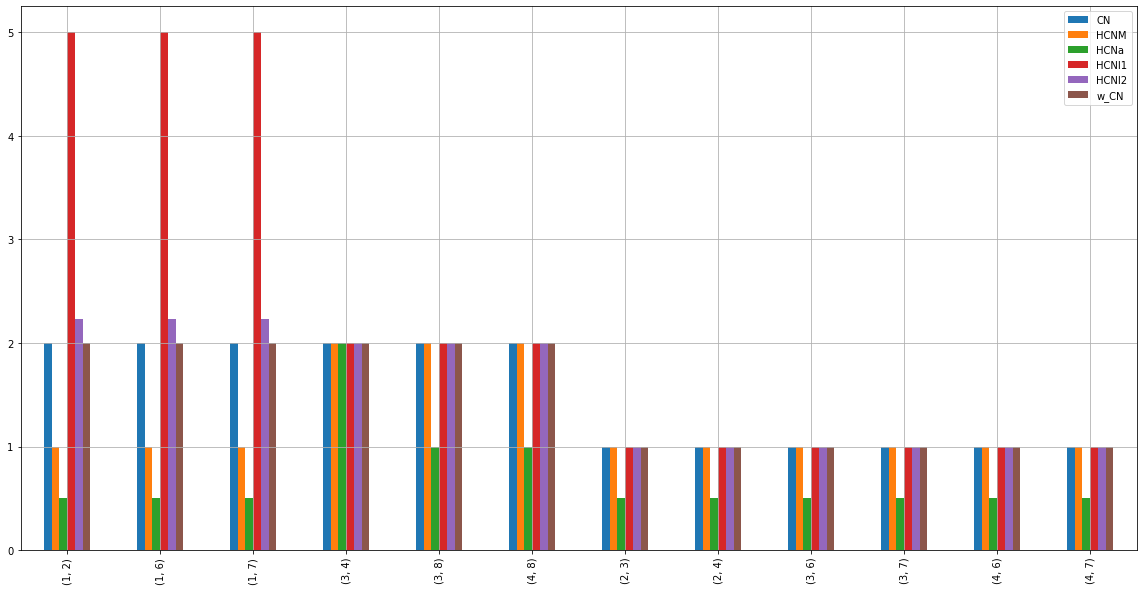

In [134]:
from matplotlib import pyplot as plt
approach = approaches[2]
columns = mcm[approach] + ['w_{}'.format(approach)]
df1 = df[columns].sort_values(approach, ascending=False)
fig, ax = plt.subplots(figsize = (20, 10))data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABHcAAAJPCAYAAAD2VjjhAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAgAElEQVR4nOzdf5TedX3n/dcHEjIcElAEIhQxEVBxzG1I5tRaoQakvS3hx+05rrrL2p1wA3rfyr1Y4GDE3rXqFsUIqMF2KWKAWim74g9kccO5JZWeLdQkjRKKtsrGFZVAoEJGCQH83H8kTCG/ZgIz3yufmcfjnBznur7f65q3b+ZcSZ65fpRaawAAAABo0169HgAAAACA50/cAQAAAGiYuAMAAADQMHEHAAAAoGHiDgAAAEDDpozHnR500EF11qxZ43HX4+qXv/xl9ttvv16PManYeffsvHt23j07756dd8/Ou2fn3bPz7tl59+y8ey3vfNWqVRtqrQdve/24xJ1Zs2Zl5cqV43HX42rFihVZsGBBr8eYVOy8e3bePTvvnp13z867Z+fds/Pu2Xn37Lx7dt69lndeSvnxjq73siwAAACAhok7AAAAAA0TdwAAAAAaNi7vuQMAAACwO5588sncf//92bRp07h+nwMOOCD33nvvuH6PF6qvry+HH354pk6dOqrzxR0AAACg5+6///7MmDEjs2bNSill3L7Pxo0bM2PGjHG7/xeq1pqHH344999/f2bPnj2q23hZFgAAANBzmzZtykte8pJxDTstKKXkJS95yW49g0ncAQAAAPYIkz3sPGN39yDuAAAAADTMe+4AAAAAe5xZH7hlTO9v3ccXjuq8Bx54IOedd16+853v5EUvelFmzpyZK664Iq961avymc98Jueee26S5H3ve18GBgYyODg4pnM+H565AwAAAJAtb2b81re+NQsWLMiPfvSjrFq1KpdccknWr1+fQw45JJ/+9KezefPmXo+5HXEHAAAAIMntt9+eqVOn5j3vec/wda973evyspe9LAcffHDe/OY359prr+3hhDsm7gAAAAAkWbt2bebPn7/T4xdddFGWLFmSp59+usOpRibuAAAAAIzCK17xirz+9a/PX/3VX/V6lOcQdwAAAACS9Pf3Z9WqVbs854Mf/GA+8YlPpNba0VQjE3cAAAAAkpx44ol54oknctVVVw1f973vfS8/+clPhi+/+tWvzmte85rcfPPNvRhxh3wUOgAAALDHGe1Hl4+lUkq+8pWv5LzzzssnPvGJ9PX1ZdasWbniiiuec97FF1+cY489tvP5dkbcAQAAANjqsMMOy4033rjd9WvXrh3++nWve11+/etfdznWLnlZFgAAAEDDxB0AAACAhok7AAAAAA0TdwAAAAAaNqo3VC6lrEuyMcnTSZ6qtQ6M51AAAAAAjM7ufFrWCbXWDeM2CQAAAAC7zUehAwAAAHueDx8wxvf36IinTJ8+PUNDQ8OXly1blpUrV2bp0qVJkuuuuy6XXnppSimZMmVKzjjjjFxwwQUZHBzMbbfdlvvuuy/Tpk3Lhg0bMjAwkHXr1mXdunWZPXt2Lr744nzsYx9LkmzYsCGHHnpo3v3udw/f9wsx2rhTkywvpdQk/7nWetW2J5RSzklyTpLMnDkzK1aseMHDde2xhx7KN6+8cqfH+/r7O5xmcrDz7tl594aGhpp8TGyZnXfPzrtn592z8+7ZeffsvHt2/q8OOOCAbNy4cfjyjDG+/2fu++mnn37O99nZeUmyadOmbN68ORs3bszy5ctz2WWX5aabbsqhhx6aJ554Il/60peycePGPPnkk9lrr73yuc99LmeddVaGhoZSa83GjRszNDSUWbNm5eabb85FF12UJLn++utzzDHHDN/3jmzatGnUPxujjTvH1Vp/Wko5JMltpZTv11q//ewTtgafq5JkYGCgLliwYJR3vef45pVX5uWf3XkxO+b793Y4zeRg592z8+6tWLEiLT4mtszOu2fn3bPz7tl59+y8e3bePTv/V/fee29mzBjrpPOvnrnvjRs37vL7PPtYX19f9tlnn8yYMSOf/vSnc9lll+WVr3zl8HnnnntukmTq1Kl5//vfnz/7sz/Lueeem+nTp6eUkhkzZmT69OnZb7/90t/fnx/84AcZGBjI1772tbzzne/Mz372s53O0tfXl2OPPXZU/99GFXdqrT/d+r8PllK+kuQ3k3x717cCAAAAaMfjjz+euXPnDl9+5JFHctpppyVJ1q5dm/nz5+/0tkcccUSOO+64XH/99Tn11FO3O/7Od74zN9xwQ2bOnJm99947hx12WH72s5+Nydwjxp1Syn5J9qq1btz69e8l+ciYfHcAAACAPcS+++6bNWvWDF9+5j13Rmvx4sU5/fTTs3Dhwu2OveUtb8kf/dEfZebMmXnHO94xJvM+Y69RnDMzyd+WUr6b5O+T3FJr/eaYTgEAAACwB+vv78+qVat2ec7RRx+duXPn5sYbb9zu2D777JP58+fnU5/6VN72treN6WwjPnOn1npfkteN6XcFAAAAaMjixYtz4YUX5pZbbslLX/rSbN68Odddd13OOuus55x38cUX7/CZO0ly/vnn501velMOPPDAMZ3NR6EDAAAAe55RfHR5l04++eSsX78+J510UmqtKaXkzDPP3O68/v7+zJs3L6tXr97hsf5x+IRicQcAAAAgWz6a/tkGBwczODg4fHnRokVZtGjRdrdbtmzZcy7fdNNNw1/PmjUra9eu3e422973CzGa99wBAAAAYA8l7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMN8FDoAAACwx5lz7Zwxvb+7/8PdI54zffr053wc+rJly7Jy5cosXbo0SXLdddfl0ksvTSklU6ZMyRlnnJELLrggg4ODue2223Lfffdl2rRp2bBhQwYGBrJu3box/f+wM565AwAAADCCW2+9NVdccUWWL1+eu+++O3feeWcOOOCA4eN77713rrnmmp7MJu4AAAAAjOCSSy7JkiVLcthhhyVJpk2blrPPPnv4+HnnnZfLL788Tz311HNuNzQ0lDe/+c2ZN29e5syZk6997WtjPpuXZQEAAAAkefzxxzN37tzhy4888khOO+20JMnatWszf/78nd72iCOOyHHHHZfrr78+p5566vD1fX19+cpXvpL9998/GzZsyG/91m/ltNNOSyllzOYWdwAAAACS7LvvvlmzZs3w5Wfec2e0Fi9enNNPPz0LFy4cvq7Wmg9+8IP59re/nb322is//elPs379+rz0pS8ds7m9LAsAAABgBP39/Vm1atUuzzn66KMzd+7c3HjjjcPXffGLX8xDDz2UVatWZc2aNZk5c2Y2bdo0prOJOwAAAAAjWLx4cS688MI88MADSZLNmzfn6quv3u68iy++OEuWLBm+/Oijj+aQQw7J1KlTc/vtt+fHP/7xmM/mZVkAAADAHmc0H13epZNPPjnr16/PSSedlFprSik588wztzuvv78/8+bNy+rVq5MkZ5xxRk499dTMmTMnAwMDefWrXz3ms4k7AAAAANnyyVbPNjg4mMHBweHLixYtyqJFi7a73bJly55z+aabbhr++qCDDsrf/d3fjemc2/KyLAAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwH4UOAAAA7HHuffUxY3p/x3z/3hHPmT59+nM+Dn3ZsmVZuXJlli5dmiS57rrrcumll6aUkilTpuSMM87IBRdckMHBwdx222257777Mm3atGzYsCEDAwNZt25d1q1bl1NOOSVr167Nww8/nLe97W35zne+k8HBweH7faE8cwcAAABgBLfeemuuuOKKLF++PHfffXfuvPPOHHDAAcPH995771xzzTW7vI++vr589KMfzZIlS8Z0NnEHAAAAYASXXHJJlixZksMOOyxJMm3atJx99tnDx88777xcfvnleeqpp3Z6H/vtt1+OO+649PX1jelsXpYFAAAAkOTxxx/P3Llzhy8/8sgjOe2005Ika9euzfz583d62yOOOCLHHXdcrr/++px66qnjPuuziTsAAAAASfbdd9+sWbNm+PIz77kzWosXL87pp5+ehQsXjsd4O+VlWQAAAAAj6O/vz6pVq3Z5ztFHH525c+fmxhtv7GiqLcQdAAAAgBEsXrw4F154YR544IEkyebNm3P11Vdvd97FF1885m+YPBIvywIAAAD2OKP56PIunXzyyVm/fn1OOumk1FpTSsmZZ5653Xn9/f2ZN29eVq9evcP7mTVrVh577LFs3rw5X/3qV7N8+fK85jWveUGziTsAAAAASYaGhp5zeXBwMIODg8OXFy1alEWLFm13u2XLlj3n8k033TT89axZs7J27drhy+vWrRuTWZ/Ny7IAAAAAGibuAAAAADRM3AEAAABomLgDAAAA0DBxBwAAAKBh4g4AAABAw3wUOgAAALDHufI93xrT+3vvn5844jnTp09/zsehL1u2LCtXrszSpUuTJNddd10uvfTSlFIyZcqUnHHGGbngggsyODiY2267Lffdd1+mTZuWDRs2ZGBgIOvWrcu6detyyimnZO3atbntttvygQ98IJs3b84+++yTT37ykznxxJHnGoln7gAAAACM4NZbb80VV1yR5cuX5+67786dd96ZAw44YPj43nvvnWuuuWaX93HQQQfl5ptvzt13351rr70273rXu8ZkNnEHAAAAYASXXHJJlixZksMOOyxJMm3atJx99tnDx88777xcfvnleeqpp3Z6H8cee+zw7fv7+/P444/niSeeeMGzeVkWAAAAQJLHH388c+fOHb78yCOP5LTTTkuSrF27NvPnz9/pbY844ogcd9xxuf7663PqqaeO+L2+/OUvZ968eZk2bdoLnlvcAQAAAEiy7777Zs2aNcOXn3nPndFavHhxTj/99CxcuHCX591zzz256KKLsnz58uc967N5WRYAAADACPr7+7Nq1apdnnP00Udn7ty5ufHGG3d6zv3335+3vvWtue6663LkkUeOyWziDgAAAMAIFi9enAsvvDAPPPBAkmTz5s25+uqrtzvv4osvzpIlS3Z4H7/4xS+ycOHCfPzjH88b3/jGMZvNy7IAAACAPc5oPrq8SyeffHLWr1+fk046KbXWlFJy5plnbndef39/5s2bl9WrV293bOnSpfnhD3+Yj3zkI/nIRz6SJFm+fHkOOeSQFzSbuAMAAACQZGho6DmXBwcHMzg4OHx50aJFWbRo0Xa3W7Zs2XMu33TTTcNfz5o1K2vXrk2SfOhDH8qHPvShsRt4Ky/LAgAAAGiYuAMAAADQMHEHAAAAoGHiDgAAAEDDxB0AAACAhok7AAAAAA3zUegAAADAHudT7zhlTO/v/L/+xpje357EM3cAAAAAnqehoaG8+93vzpFHHpn58+dnwYIFueuuu5IkpZScf/75w+cuWbIkH/7wh8d8BnEHAAAA4Hk666yzcuCBB+af//mfs2rVqnzhC1/Ihg0bkiTTpk3LTTfdNHx5vIg7AAAAAEk++clP5jOf+UyS5P3vf39OPPHEJMm3vvWtnHHGGdud/6Mf/Sh33XVXPvaxj2WvvbYkltmzZ2fhwoVJkilTpuScc87J5ZdfPq5zizsAAAAASY4//vjccccdSZKVK1dmaGgoTz75ZO644478zu/8znbn33PPPZk7d2723nvvnd7ne9/73nzxi1/Mo48+Om5zizsAAAAASebPn59Vq1blsccey7Rp0/KGN7whK1euzB133JHjjz/+ed3n/vvvnz/4gz8YfkbQeBB3AAAAAJJMnTo1s2fPzrJly/Lbv/3bOf7443P77bfnhz/8YY455pjtzu/v7893v/vdPP3007u83/POOy+f//zn88tf/nJc5vZR6AAAAMAep1cfXX788cdnyZIlueaaazJnzpz84R/+YebPn59SynbnHnnkkRkYGMgf//Ef56Mf/WhKKVm3bl3uueee4ffdSZIDDzwwb3/72/P5z38+Z5555pjP7Jk7AAAAAFsdf/zx+fnPf543vOENmTlzZvr6+nb5kqyrr74669evz1FHHZXXvva1GRwczCGHHLLdeeeff/64fWqWZ+4AAAAAbPXmN785Tz755PDlf/qnf9rl+fvvv3/+4i/+YofHhoaGhr+eOXNmfvWrX43NkNvwzB0AAACAhnnmDgAAAMAIXv/61+eJJ554znXXX3995syZ06OJ/pW4AwAAAOwRaq07fOPiPcFdd93V2feqte7W+V6WBQAAAPRcX19fHn744d0OGxNNrTUPP/xw+vr6Rn0bz9wBAAAAeu7www/P/fffn4ceemhcv8+mTZt2K5z0Ql9fXw4//PBRny/uAAAAAD03derUzJ49e9y/z4oVK3LssceO+/fpkpdlAQAAADRM3AEAAABomLgDAAAA0DBxBwAAAKBh4g4AAABAw8QdAAAAgIaJOwAAAAANE3cAAAAAGibuAAAAADRM3AEAAABomLgDAAAA0DBxBwAAAKBh4g4AAABAw8QdAAAAgIaJOwAAAAANE3cAAAAAGibuAAAAADRM3AEAAABomLgDAAAA0DBxBwAAAKBh4g4AAABAw8QdAAAAgIaJOwAAAAANE3cAAAAAGibuAAAAADRM3AEAAABo2KjjTill71LKP5RSvjGeAwEAAAAwervzzJ3/mOTe8RoEAAAAgN03qrhTSjk8ycIkV4/vOAAAAADsjlJrHfmkUv5rkkuSzEhyQa31lB2cc06Sc5Jk5syZ82+44YYxHnX8PfbQQ9nnwQd3eryvv7/DaSYHO++enXdvaGgo06dP7/UYk4qdd8/Ou2fn3bPz7tl59+y8e3bevZZ3fsIJJ6yqtQ5se/2UkW5YSjklyYO11lWllAU7O6/WelWSq5JkYGCgLliw01P3WN+88sq8/LNLd3r8mO97VdpYs/Pu2Xn3VqxYkRYfE1tm592z8+7ZeffsvHt23j07756dd28i7nw0L8t6Y5LTSinrktyQ5MRSyl+O61QAAAAAjMqIcafWurjWenitdVaSdyb5Vq3134/7ZAAAAACMaHc+LQsAAACAPcyI77nzbLXWFUlWjMskAAAAAOw2z9wBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRsx7pRS+kopf19K+W4p5Z5Syp90MRgAAAAAI5syinOeSHJirXWolDI1yd+WUm6ttd45zrMBAAAAMIIR406ttSYZ2npx6tZfdTyHAgAAAGB0ypZ2M8JJpeydZFWSo5JcWWu9aAfnnJPknCSZOXPm/BtuuGGMRx1/jz30UPZ58MGdHu/r7+9wmsnBzrtn590bGhrK9OnTez3GpGLn3bPz7tl59+y8e3bePTvvnp13r+Wdn3DCCatqrQPbXj+quDN8cikvSvKVJOfWWtfu7LyBgYG6cuXK5zVoL33zyivz8s8u3enxY75/b4fTTA523j07796KFSuyYMGCXo8xqdh59+y8e3bePTvvnp13z867Z+fda3nnpZQdxp3d+rSsWusvktye5C1jNRgAAAAAz99oPi3r4K3P2EkpZd8kv5vk++M9GAAAAAAjG82nZR2a5Nqt77uzV5Iba63fGN+xAAAAABiN0Xxa1veSHNvBLAAAAADspt16zx0AAAAA9iziDgAAAEDDxB0AAACAhok7AAAAAA0TdwAAAAAaJu4AAAAANEzcAQAAAGiYuAMAAADQMHEHAAAAoGHiDgAAAEDDxB0AAACAhok7AAAAAA0TdwAAAAAaJu4AAAAANEzcAQAAAGiYuAMAAADQMHEHAAAAoGHiDgAAAEDDxB0AAACAhok7AAAAAA0TdwAAAAAaJu4AAAAANEzcAQAAAGiYuAMAAADQMHEHAAAAoGHiDgAAAEDDxB0AAACAhok7AAAAAA0TdwAAAAAaJu4AAAAANEzcAQAAAGiYuAMAAADQMHEHAAAAoGHiDgAAAEDDxB0AAACAhok7AAAAAA0TdwAAAAAaJu4AAAAANEzcAQAAAGiYuAMAAADQMHEHAAAAoGHiDgAAAEDDxB0AAACAhok7AAAAAA0TdwAAAAAaJu4AAAAANEzcAQAAAGiYuAMAAADQMHEHAAAAoGHiDgAAAEDDxB0AAACAhok7AAAAAA0TdwAAAAAaJu4AAAAANEzcAQAAAGiYuAMAAADQMHEHAAAAoGHiDgAAAEDDxB0AAACAhok7AAAAAA0TdwAAAAAaJu4AAAAANEzcAQAAAGiYuAMAAADQMHEHAAAAoGHiDgAAAEDDxB0AAACAhok7AAAAAA0TdwAAAAAaJu4AAAAANEzcAQAAAGiYuAMAAADQMHEHAAAAoGHiDgAAAEDDpvR6gJZc+Z5v7fL4e//8xI4mmTzsvHt2DgAA0BbP3AEAAABomLgDAAAA0DBxBwAAAKBh4g4AAABAw8QdAAAAgIaJOwAAAAANE3cAAAAAGibuAAAAADRM3AEAAABomLgDAAAA0DBxBwAAAKBh4g4AAABAw8QdAAAAgIaJOwAAAAANE3cAAAAAGibuAAAAADRM3AEAAABomLgDAAAA0DBxBwAAAKBh4g4AAABAw0aMO6WUl5VSbi+l/GMp5Z5Syn/sYjAAAAAARjZlFOc8leT8WuvqUsqMJKtKKbfVWv9xnGcDAAAAYAQjPnOn1vrzWuvqrV9vTHJvkt8Y78EAAAAAGFmptY7+5FJmJfl2ktfWWh/b5tg5Sc5JkpkzZ86/4YYbxm7KZ7n7p4/u8vic3zjged/3Yw89lH0efHCnxzfOOGKXt//1U+t3emzmK4563nP1mp13z867N+LO9/qfOz32j/vss8vbHv7rg+18B17IznPo3F3e1s/5jtn5xDI0NJTp06f3eoxJxc67Z+fds/Pu2Xn3Wt75CSecsKrWOrDt9aOOO6WU6Un+Jsl/qrXetKtzBwYG6sqVK5/XoCOZ9YFbdnl83ccXPu/7/uaVV+bln1260+PfWnDlLm+/6V8u2+mx8//6G897rl6z8+7ZefdG3Hnfv9vpsTmzd/2X1k8OvcfOd+CF7Dwf3nWk8HO+Y3Y+saxYsSILFizo9RiTip13z867Z+fds/PutbzzUsoO486oPi2rlDI1yZeTfHGksAMAAABAd0bzaVklyeeT3Ftr3fk/qwEAAADQudE8c+eNSd6V5MRSypqtv04e57kAAAAAGIURPwq91vq3SUoHswAAAACwm0b1njsAAAAA7JnEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaNiIcaeUck0p5cFSytouBgIAAABg9EbzzJ1lSd4yznMAAAAA8DyMGHdqrd9O8kgHswAAAACwm7znDgAAAEDDSq115JNKmZXkG7XW1+7inHOSnJMkM2fOnH/DDTeM0YjPdfdPH93l8f3ZqnsAAA8tSURBVDl7/c+dHzx07i5v+9hDD2WfBx/c6fGNM47Y5e1//dT6nR6b+YqjdnnbPZmdd8/Ou/dCdv6P++yzy9se/uuD7XwH7Lx7dt49j+fds/Pu2Xn37Lx7dt49O9+xE044YVWtdWDb68cs7jzbwMBAXbly5e7OOCqzPnDLLo+v6/t3Oz/44V3/cHzzyivz8s8u3enxby24cpe33/Qvl+302Pl//Y1d3nZPZufds/PuvZCdz5m96wf/Tw69x853wM67Z+fd83jePTvvnp13z867Z+fds/MdK6XsMO54WRYAAABAw0bzUehfSvJ3SV5VSrm/lPJ/jv9YAAAAAIzGlJFOqLX+2y4GAQAAAGD3eVkWAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaJi4AwAAANAwcQcAAACgYeIOAAAAQMPEHQAAAICGiTsAAAAADRN3AAAAABom7gAAAAA0TNwBAAAAaNiUXg/QpTnXztnl8U/mPR1NMnnYeffsHGBi8HjePTvvnp13z867Z+fdm4w798wdAAAAgIaJOwAAAAANE3cAAAAAGibuAAAAADRM3AEAAABomLgDAAAA0DBxBwAAAKBh4g4AAABAw8QdAAAAgIaJOwAAAAANE3cAAAAAGibuAAAAADRM3AEAAABomLgDAAAA0DBxBwAAAKBh4g4AAABAw8QdAAAAgIaJOwAAAAANE3cAAAAAGibuAAAAADRM3AEAAABomLgDAAAA0DBxBwAAAKBh4g4AAABAw8QdAAAAgIaJOwAAAAANE3cAAAAAGibuAAAAADRM3AEAAABomLgDAAAA0DBxBwAAAKBh4g4AAABAw8QdAAAAgIaJOwAAAAANE3cAAAAAGibuAAAAADRM3AEAAABomLgDAAAA0DBxBwAAAKBh4g4AAABAw8QdAAAAgIaJOwAAAAANE3cAAAAAGibuAAAAADRM3AEAAABomLgDAAAA0DBxBwAAAKBh4g4AAABAw0YVd0opbyml/KCU8sNSygfGeygAAAAARmfEuFNK2TvJlUl+P8lrkvzbUsprxnswAAAAAEY2mmfu/GaSH9Za76u1bk5yQ5LTx3csAAAAAEaj1Fp3fUIpb0vyllrrWVsvvyvJ62ut79vmvHOSnLP14quS/GDsxx13ByXZ0OshJhk7756dd8/Ou2fn3bPz7tl59+y8e3bePTvvnp13r+Wdv7zWevC2V04Zq3uvtV6V5Kqxur9eKKWsrLUO9HqOycTOu2fn3bPz7tl59+y8e3bePTvvnp13z867Z+fdm4g7H83Lsn6a5GXPunz41usAAAAA6LHRxJ3vJDm6lDK7lLJPkncm+fr4jgUAAADAaIz4sqxa61OllPcl+e9J9k5yTa31nnGfrDeafllZo+y8e3bePTvvnp13z867Z+fds/Pu2Xn37Lx7dt69CbfzEd9QGQAAAIA912helgUAAADAHkrcAQAAAGiYuAMAAADQsBHfUBmA3VNK6UtySpLjkxyW5PEka5PcMoHfkL6n7Lx7dt69Usrh2fKppdvtPMmttdZf93C8CcnOu2fn3bPz7tl59ybDzif1GyqXUt6Q5N9ny3/gQ/Pc/8B/WWt9tIfjTUh23j0771Yp5U+y5S+8K5KsSvJgkr4kr0xywtavz6+1fq9XM040dt49O+9eKeULSX4jyTeSrMz2O5+f5AO11m/3bMgJxs67Z+fds/Pu2Xn3JsvOJ23cKaXcmuRnSb6WHf8HPjXJZbXWr/dsyAnGzrtn590rpSystd6yi+OHJDmi1rqyw7EmNDvvnp13r5Ty2lrr2l0c3ydbdv7DDsea0Oy8e3bePTvvnp13b7LsfDLHnYNqrRte6DmMnp13z873DKWUQ2qtD/Z6DgBemFLKvFrr6l7PMZmUUl5Sa32413PAePJzzliYtG+oPJq/zPoL79jadp+llP1LKfNLKS/e2Tm8MH7Ou1dKOXCbXy9J8vellBeXUg7s9XwTUSlloJRyeynlL0spLyul3FZKebSU8p1SyrG9nm8isvPulVJeXUq5tZRySynlyFLKslLKL0opf19KOabX801EpZR52/yan+TrpZRjSynzej3fRFRK+Xgp5aCtXw+UUu5Lclcp5cellDf1eLwJqZSyupTyoVLKkb2eZbLwc969yfJzPmnjztY/jN5QSrmjlPLBUsrUZx37ai9nm6i2/iXgmQey/z1b3vflE0nWlFL+TU+Hm6BKKY+UUq4upby5lFJ6Pc8ksSFb3oPkmV8rs+U1vqu3fs3Y+1ySS7PlfaT+R5L/XGs9IMkHth5j7Nl5967Klt3+ZZJvJflmkhcn+WiSpT2cayJbmS27/dTWX0uSvCTJZVu/ZuwtfNY/On0yyTtqrUcl+d1s+W/A2HtxkhcluX1rLH5/KeWwXg81wfk5796k+DmftHEnyTXZ8kaQ52bLm8z+zdZ/YU+Sl/dqqAnudc96IPvjJL9Taz0pW97A6kO9G2tCeyjJmiQfSXJ/KeXTpZTf6vFME92FSX6Q5LRa6+xa6+wk92/9+hU9nm2imlprvbXW+qUktdb6X7Pli/8vW95jirFn592bUWu9eevOn6y13lC3uDlb/tDK2Ps3SZ5Mcmmt9YRa6wlJHtj69Yk9nm2imlJKeebTfPettX4nSWqt/5RkWu/GmtD+pdZ6Qa31iCTnJzk6yeqtz848p8ezTVR+zrs3KX7OJ3PcObjW+ue11jW11nOz5V/Dvr31qVqT842Ixt9epZT9t3796yT/Kxl+WdCUnd6KF+KXtdaltdY3JnlDkp8m+Vwp5b5Syp/2eLYJqdb6qSRnJfl/SymXlVJmxGPKeNtUSvm9rc8ArKWU/yNJtj61+enejjZh2Xn39n7W15dtc2yfLgeZLGqtX06yMMnvlVL+SynliHg8H2+fS/LfSiknJvnm1n+UelPZ8gl9a3o824RXa72j1vp/Z8szjj+RLX92ZOz5Oe+hifxzPpnfUPmeJPNrrZuedd1JSf48yX611kN7NtwEVUp5e5KLklyZ5FVJjkry9Wz51KaHa63n93C8CamU8g+11u3e/6KU8upseQron/RgrEmjlHJakg8mmVVrfWmv55moSimvy5aXCP06yfuT/F9J/kO2xMyza63/o4fjTUh23r1SyruTfLHWOrTN9UcleV+t9bzeTDY5bH0vqcuS9NdaD+n1PBNZKWVBtjymvDJb/vHvJ0m+muQLtdYnezjahFRKuaHW+s5ezzHZ+Dnv1mT5OZ/Mcef9SVbXWv9mm+uPzZan3/5ubyab2Lb+IfTs/OsD2f1Jvlpr/e89HWyCKqVcVmv9w17PMZmVUvZNcuSuPn4RgD3f1veum1FrfazXswDAtiZt3AEAAACYCCbze+4AAAAANE/cAQAAAGiYuAPQgVLKQCnlsF7PMZnYeffsvHullNNLKa/v9RyTiZ13z2NL9+y8e3bevYm2c3FnG37D7p6dd8/Oe+LcJLeUUv6614NMInbePTvv3uuTfKiUcmuvB5lE7Lx7Hlu6Z+fds/PuTaide0PlbZRS/jTJnCRTaq2/3+t5JgM7756d904pZUatdWOv55hM7Lx7dg6MB48t3bPz7tl59ybKzsUdgDFWSnlpktRaHyilHJzk+CQ/qLXe09vJJi47771Syp/WWj/Y6zkmslLK/kkOrrX+aJvr/7da6/d6NNaEZufd83jePTvvPb+Hdm8i7lzc2YFSyu/WWm/r9RyTiZ13z87HRynl3Uk+kKQk+USSwSRrkxyX5NJa6+d7N93EZOfdK6V8ZturkrwryXVJUmv9fzofaoIrpbw9yRVJHkwyNclgrfU7W4+trrXO6+V8E5Gdd8/jeffsvHt+D+3eZNm5uLMDpZT/VWs9otdzTCZ23j07Hx+llLuz5f0Y9k3y4yRHbf2XsBcnub3WOrenA05Adt69UspPkvxNkuXZ8gekJFmS5IIkqbVe26PRJqxSypokv19r/Xkp5Tez5Q+ki2utXyml/EOt9dgejzjh2Hn3PJ53z8675/fQ7k2WnU/p9QC9Ukr5+s4OJXlJl7NMFnbePTvviSdrrb9K8qv/v707dm0qCsMw/r6Uljrr6iBuOgrO2qng5OKiUHBTEIS6O/g/OOvgKCjorIKDCOLs4CKibhYqOjh8DkkhBsQMzXuac57feJPh40m4N5zcnNj+WFXfJKmqvttmNX05aJ53RtI9SduS7lTVF9t3e/lwdEStVdVXSaqqt7YvSnpm+6Qk3ufLQfM8zud5NM/jGpo3RPNhF3c0+S3pNUk/5o5b0vn8OEOgeR7N88r2elX9lnTp4KDtTfEPhctC87DppoO3bZ+T9Mj2c9F62fZtnz7Y+2V6N8kFSU8knW06Wb9onsf5PI/mYVxD80ZpPvLizhtJP6vq1fwDtj80mGcENM+jed5lTb/RrarPM8ePS9ptMlH/aN5IVb2zvSXppqTXrefp3A3NfRCtqn3b25KutBmpezTP43yeR/NGuIbm9d6cPXcA4BDZdv3nxLrIc7A4mufRPI/meTTPo3kezfNonjdK8+5uRVqUbR/Gc7A4mufRvIkXtm/Z/muzatsbtrdsP5S002i2XtE8j+Z5NM+jeR7N82ieR/O8IZoPe+eO7ZeSHkt6WlWfZo5vaPLXfzua7BD/oMmAHaJ5Hs3zpr9Rvy7pqqRTkvYkbUpa02SH/vtV9b7dhP2hed4/mh/T5Esjmi8B7/M8mufRPI/meVxD80ZpPvLiDieyMJrn0bwt2+uSTkj6VVV7recZAc3zaJ5H8zya59E8j+Z5NM/rufmwizuzen6Bjyqa59EcAAAAAPrE4g4AAAAAAMAKG3ZDZQAAAAAAgB6wuAMAAAAAALDCWNwBAAAAAABYYSzuAAAAAAAArLA/ImN/Tq37ntwAAAAASUVORK5CYII=
df1.plot(kind='bar', ax=ax, grid = True)

In [127]:
from information_calculator import get_entropy
columns = mcm[approach]
for col in columns:
    scores = np.array(list(df[col]))
    print(col, get_entropy(scores))

AS 3.39015461809847
HASM 3.4552570819816015
HASa 3.2737372088322316
HASl1 3.229067773571208
HASl2 3.4386014660562387


In [11]:
linkpred_indices=[0, 1, 2, 5, 6, 8, 10, 11, 12, 13]
hypergraph_score_indices=[8, 9, 11, 12, 30, 31, 33, 34, 52, 53, 55, 56, 37, 38, 40, 41, 14, 16, 17, 19, 20, 1, 2, 4, 5, 66, 67, 69, 70, 59, 60, 62, 63, 44, 45, 47, 48, 23, 24, 26, 27]

In [12]:

default_lp_cols = ['AA', 'AS', 'CN', 'Cos', 'PA', 'JC', 'MxO', 'MnO', 'NM', 'Prn']
abbr_pred_map = {a: p for p, a in predictor_abbr_map.items()}
default_lp_names = [abbr_pred_map[a] for a in default_lp_cols]
default_lp_indices = [all_predictor_names.index(p) for p in default_lp_names]

metrics = ['ap', 'auc', 'p@+', 'p@10', 'p@100', 'r@+', 'r@10', 'r@100']
default_hyper_cols = ['HAAM', 'HAAa', 'HAAl1', 'HAAl2',
                      'HASM', 'HASa', 'HASl1', 'HASl2',
                      'HCNM', 'HCNa', 'HCNl1', 'HCNl2',
                      'HCosM', 'HCosa', 'HCosl1', 'HCosl2',
                      'HDPa', 'HPM', 'HPa', 'HPl1', 'HPl2',
                      'HJCM', 'HJCa', 'HJCl1', 'HJCl2',
                      'HmaxoM', 'HmaxoA', 'Hmaxol1', 'Hmaxol2',
                      'HminoM', 'HminoA', 'Hminol1', 'Hminol2',
                      'HNMM', 'HNMa', 'HNMl1', 'HNMl2',
                      'HPearM', 'HPeara', 'HPearl1', 'HPearl2',
                      ]
hyg_abbr_pred_map = {a: p for p, a in hypergraph_score_abbr_map.items()}
default_hyg_names = [hyg_abbr_pred_map[a] for a in default_hyper_cols]
default_hyper_indices = [all_hypergraph_score_names.index(p) for p in default_hyg_names]

combined_tables = {}
mixed_combinations_map = {'AA': ['AA', 'HAAM', 'HAAa', 'HAAl1', 'HAAl2'],
                          'AS': ['AS', 'HASM', 'HASa', 'HASl1', 'HASl2'],
                          'CN': ['CN', 'HCNM', 'HCNa', 'HCNl1', 'HCNl2'],
                          'Cos': ['Cos', 'HCosM', 'HCosa', 'HCosl1', 'HCosl2'],
                          'PA': ['PA', 'HDPa', 'HPM', 'HPa', 'HPl1', 'HPl2'],
                          'JC': ['JC', 'HJCM', 'HJCa', 'HJCl1', 'HJCl2'],
                          'Kz': ['Kz', 'HKz'],
                          'MxO': ['MxO', 'HmaxoM', 'HmaxoA', 'Hmaxol1', 'Hmaxol2'],
                          'MnO': ['MnO', 'HminoM', 'HminoA', 'Hminol1', 'Hminol2'],
                          'NM': ['NM', 'HNMM', 'HNMa', 'HNMl1', 'HNMl2'],
                          'Prn': ['Prn', 'HPearM', 'HPeara', 'HPearl1', 'HPearl2'], }
from src.utils import get_library_path

library_path = get_library_path()
sys.path.append(library_path)
sys.path.append(os.path.join(library_path, 'hynetworkx'))
from linkpred import linkpred
import pandas as pd
from scipy.sparse import triu
import networkx as nx
import pickle
from tqdm import tqdm

base_path = '/content/gdrive/My Drive/Colab Notebooks/data/'

all_predictor_names = ['AdamicAdar',  # 0
                       'AssociationStrength',  # 1
                       'CommonNeighbours',  # 2
                       'Community',  # 3
                       'Copy',  # 4
                       'Cosine',  # 5
                       'DegreeProduct',  # 6
                       'GraphDistance',  # 7
                       'Jaccard',  # 8
                       'Katz',  # 9
                       'MaxOverlap',  # 10
                       'MinOverlap',  # 11
                       'NMeasure',  # 12
                       'Pearson',  # 13
                       'Random',  # 14
                       'ResourceAllocation',  # 15
                       'RootedPageRank',  # 16
                       'SimRank',  # 17
                       ]

# all_predictor_names = ['Random','AdamicAdar', 'CommonNeighbours', 'Cosine', 'DegreeProduct', 'Jaccard', 'Katz',
# 'SimRank']
predictor_abbr_map = {'AdamicAdar': 'AA',
                      'AssociationStrength': 'AS',
                      'CommonNeighbours': 'CN',
                      'Community': 'Comm',
                      'Copy': 'Cpy',
                      'Cosine': 'Cos',
                      'DegreeProduct': 'PA',
                      'GraphDistance': 'GD',
                      'Jaccard': 'JC',
                      'Katz': 'Kz',
                      'MaxOverlap': 'MxO',
                      'MinOverlap': 'MnO',
                      'NMeasure': 'NM',
                      'Pearson': 'Prn',
                      'Random': 'Rnd',
                      'ResourceAllocation': 'RA',
                      'RootedPageRank': 'RPR',
                      'SimRank': 'SR'}

all_predictors = [eval('linkpred.predictors.{}'.format(x)) for x in all_predictor_names]



In [13]:
import os

import numpy as np
import pandas as pd
from scipy.sparse import triu
import pickle
from collections import defaultdict
from tqdm import tqdm
import sys

from src.data_preparer import S_to_A, S_to_B, incidence_to_hyperedges, prepare_node_hyperneighbors_map
from src.utils import get_library_path, get_base_path

In [58]:
adj.todense()

matrix([[0, 0, 1, 1, 1, 0, 0, 1],
        [0, 0, 0, 0, 1, 1, 1, 1],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [1, 1, 1, 1, 0, 1, 1, 1],
        [0, 1, 0, 0, 1, 0, 1, 1],
        [0, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 1, 1, 0]])

In [65]:
weighted_linkpred_scores_df = get_linkpred_scores1(weighted_lp_data, True,A, G,linkpred_indices)

Predictor: 100%|██████████| 10/10 [00:00<00:00, 316.39it/s]

12
0
Preparing predictor AA
Performing prediction...
Done
1
Preparing predictor AS
Performing prediction...
Done
2
Preparing predictor CN
Performing prediction...
Done
3
Preparing predictor Cos
Performing prediction...
Done
4
Preparing predictor PA
Performing prediction...
Done
5
Preparing predictor JC
Performing prediction...
Done
6
Preparing predictor MxO
Performing prediction...
Done
7
Preparing predictor MnO
Performing prediction...
Done
8
Preparing predictor NM
Performing prediction...
Done
9
Preparing predictor Prn
Performing prediction...
Done


In [68]:
unweighted_linkpred_scores_df = get_linkpred_scores1(weighted_lp_data, False, A,G,linkpred_indices)

Predictor: 100%|██████████| 10/10 [00:00<00:00, 691.58it/s]

12
Preparing predictor AA
Performing prediction...
Done
Preparing predictor AS
Performing prediction...
Done
Preparing predictor CN
Performing prediction...
Done
Preparing predictor Cos
Performing prediction...
Done
Preparing predictor PA
Performing prediction...
Done
Preparing predictor JC
Performing prediction...
Done
Preparing predictor MxO
Performing prediction...
Done
Preparing predictor MnO
Performing prediction...
Done
Preparing predictor NM
Performing prediction...
Done
Preparing predictor Prn
Performing prediction...
Done


In [85]:
hyg_df

Hmaxom    HmaxoM    HmaxoA    Hmaxos   Hmaxol1   Hmaxol2   Hmaxol3  \
0 1  0.000000  0.250000  0.125000  1.250000  1.250000  0.559017  0.559017   
  5  0.000000  0.250000  0.125000  1.250000  1.250000  0.559017  0.559017   
  6  0.000000  0.250000  0.125000  1.250000  1.250000  0.559017  0.559017   
1 2  0.000000  0.250000  0.125000  0.250000  0.250000  0.250000  0.250000   
  3  0.000000  0.250000  0.125000  0.250000  0.250000  0.250000  0.250000   
2 3  0.666667  0.666667  0.666667  0.666667  0.666667  0.666667  0.666667   
  5  0.000000  0.250000  0.125000  0.250000  0.250000  0.250000  0.250000   
  6  0.000000  0.250000  0.125000  0.250000  0.250000  0.250000  0.250000   
  7  0.000000  0.666667  0.333333  0.666667  0.666667  0.666667  0.666667   
3 5  0.000000  0.250000  0.125000  0.250000  0.250000  0.250000  0.250000   
  6  0.000000  0.250000  0.125000  0.250000  0.250000  0.250000  0.250000   
  7  0.000000  0.666667  0.333333  0.666667  0.666667  0.666667  0.666667   

       HPearm    HPearM    HPeara  ...     HASl1     HASl2     HASl3  \
0 1  0.000000  0.000000  0.000000  ...  0.458333  0.208333  0.208333   
  5  0.000000  0.000000  0.000000  ...  0.458333  0.208333  0.208333   
  6  0.000000  0.000000  0.000000  ...  0.458333  0.208333  0.208333   
1 2  0.000000  0.000000  0.000000  ...  0.083333  0.083333  0.083333   
  3  0.000000  0.000000  0.000000  ...  0.083333  0.083333  0.083333   
2 3  0.466667  0.466667  0.466667  ...  0.222222  0.222222  0.222222   
  5  0.000000  0.000000  0.000000  ...  0.083333  0.083333  0.083333   
  6  0.000000  0.000000  0.000000  ...  0.083333  0.083333  0.083333   
  7  0.000000  0.466667  0.233333  ...  0.222222  0.222222  0.222222   
3 5  0.000000  0.000000  0.000000  ...  0.083333  0.083333  0.083333   
  6  0.000000  0.000000  0.000000  ...  0.083333  0.083333  0.083333   
  7  0.000000  0.466667  0.233333  ...  0.222222  0.222222  0.222222   

         HAAm      HAAM      HAAa      HAAs     HAAl1     HAAl2     HAAl3  
0 1  0.000000  0.590616  0.212351  2.123513  2.123513  0.967611  0.967611  
  5  0.000000  0.590616  0.212351  2.123513  2.123513  0.967611  0.967611  
  6  0.000000  0.590616  0.212351  2.123513  2.123513  0.967611  0.967611  
1 2  0.000000  0.383224  0.191612  0.383224  0.383224  0.383224  0.383224  
  3  0.000000  0.383224  0.191612  0.383224  0.383224  0.383224  0.383224  
2 3  0.766449  0.766449  0.766449  0.766449  0.766449  0.766449  0.766449  
  5  0.000000  0.383224  0.191612  0.383224  0.383224  0.383224  0.383224  
  6  0.000000  0.383224  0.191612  0.383224  0.383224  0.383224  0.383224  
  7  0.000000  0.766449  0.383224  0.766449  0.766449  0.766449  0.766449  
3 5  0.000000  0.383224  0.191612  0.383224  0.383224  0.383224  0.383224  
  6  0.000000  0.383224  0.191612  0.383224  0.383224  0.383224  0.383224  
  7  0.000000  0.766449  0.383224  0.766449  0.766449  0.766449  0.766449  

[12 rows x 72 columns]

In [84]:
hyg_df = get_hypergraph_scores1(weighted_lp_data,A,S, score_indices=None)

Test pair: 100%|██████████| 12/12 [00:00<00:00, 16567.36it/s]

Test pair: 100%|██████████| 12/12 [00:00<00:00, 11809.40it/s]

Test pair: 100%|██████████| 12/12 [00:00<00:00, 57000.73it/s]

Test pair: 100%|██████████| 12/12 [00:00<00:00, 7042.35it/s]

Test pair: 100%|██████████| 12/12 [00:00<00:00, 3078.20it/s]

Test pair: 100%|██████████| 12/12 [00:00<00:00, 13425.35it/s]

Matrix power:   0%|          | 0/5 [00:00<?, ?it/s]

Test pair: 100%|██████████| 12/12 [00:00<00:00, 1803.61it/s]


Test pair: 100%|██████████| 12/12 [00:00<00:00, 4599.86it/s]


Test pair: 100%|██████████| 12/12 [00:00<00:00, 4643.57it/s]


Test pair: 100%|██████████| 12/12 [00:00<00:00, 3147.50it/s]


Test pair: 100%|██████████| 12/12 [00:00<00:00, 15069.36it/s]

Test pair:   0%|          | 0/12 [00:00<?, ?it/s]

Converting incidence matrix to hyperedge <class 'set'> for faster processing...
Precomputing node-hyperneighbor map...
Calculating hypergraph scores: HyperMaxOverlap
Calculating hypergraph scores: HyperPearson
Calculating hypergraph scores: HyperDegreeProduct
Calculating hypergraph scores: HyperCommonNeighbour
Calculating hypergraph scores: HyperNMeasure
Calculating hypergraph scores: HyperJaccard
Calculating hypergraph scores: HyperKatz
Finding A and B from S
Iterating over matrix powers...
Calculating hypergraph scores: HyperMinOverlap
Calculating hypergraph scores: HyperProduct


Test pair: 100%|██████████| 12/12 [00:00<00:00, 13464.86it/s]

Test pair: 100%|██████████| 12/12 [00:00<00:00, 11259.88it/s]

Test pair: 100%|██████████| 12/12 [00:00<00:00, 14984.12it/s]

Hypergraph score: 100%|██████████| 12/12 [00:00<00:00, 56.33it/s]


Calculating hypergraph scores: HyperCosine
Calculating hypergraph scores: HyperAssociationStrength
Calculating hypergraph scores: HyperAdamicAdar


In [8]:
import argparse
import sys
import os
from collections import defaultdict
from pprint import pprint
from tqdm import tqdm
sys.path.append('../')
from src.utils import get_data_abbr, mkdir_p, get_base_path, get_library_path
import pandas as pd
import numpy as np
library_path = get_library_path()
sys.path.append(library_path)
sys.path.append(os.path.join(library_path, "hynetworkx"))
from src.data_preparer import filter_size, prepare_lp_data, get_time_filter_params,incidence_to_hyperedges, S_to_A
from src.hypergraph_link_predictor import get_hypergraph_scores, hypergraph_score_abbr_map, all_hypergraph_score_names
from src.link_predictor import get_perf_df
from src.linkpred_predictor import get_linkpred_scores, predictor_abbr_map, all_predictor_names
from src.supervised_link_predictor import classify
from src.experimenter import perform_GWH_classification
from src.incidence_matrix import parse_benson_incidence_matrix as parse_S
from experimenter import *
from experimenter import *
from utils import *
import pandas as pd
import numpy as np
from itertools import product
from tqdm import tqdm_notebook
from tabulate import tabulate
from joblib import Memory
import networkx as nx

from scipy.sparse import csr_matrix, triu, hstack, find
base_path = get_base_path()


# We have S,G,

In [59]:
def get_dummy_hypergraph():
    I = [1, 5, 1, 5, 8, 2, 5, 6, 7, 1, 3, 5, 2, 6, 7, 8, 1, 5, 4, 1]
    J = [1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7]
    I = [i - 1 for i in I]
    J = [j - 1 for j in J]
    V = [1] * len(I)
    S = csr_matrix((V, (I, J)))
    return S
G = nx.from_scipy_sparse_matrix(S_to_A(get_dummy_hypergraph(),False))
# nx.draw(G, node_color='r', with_labels=True)
hyperedge_times=[]
for i in range(7):
    hyperedge_times.append(0)
hyperedge_times=np.array(hyperedge_times)
S=get_dummy_hypergraph()
def parse_s_w():
    return S,hyperedge_times

In [60]:
adj=nx.adj_matrix(G)

In [61]:
adj.todense()

matrix([[0, 0, 1, 1, 1, 0, 0, 1],
        [0, 0, 0, 0, 1, 1, 1, 1],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [1, 1, 1, 1, 0, 1, 1, 1],
        [0, 1, 0, 0, 1, 0, 1, 1],
        [0, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 1, 1, 0]], dtype=int64)

In [64]:
adj=((adj==0)*1)
adj.setdiag(0)
adj.eliminate_zeros()
# adj.todense()
A=adj
A.todense()

matrix([[0, 1, 0, 0, 0, 1, 1, 0],
        [1, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 1, 1],
        [0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0]])

In [14]:
def get_linkpred_scores1(lp_data, weighted,A,G, predictor_indices=None):
    predictor_indices = predictor_indices or range(len(all_predictors))
    predictors = [all_predictors[i] for i in predictor_indices]
    predictor_names = [all_predictor_names[i] for i in predictor_indices]
#     A_train = lp_data['A_train']
#     A_test = lp_data['A_test']
#     A_test_pos = lp_data['A_test_pos']
#     A_test_neg = lp_data['A_test_neg']
#     G_train = nx.from_scipy_sparse_matrix(A_train)
    test_pairs = list(zip(*triu(A).nonzero()))
    print(len(test_pairs))
    scores = {}
    if weighted:
        for i in tqdm(range(len(predictors)), 'Predictor: '):
            print(i)
            predictor = predictors[i]
            abbr = predictor_abbr_map[predictor_names[i]]
            print('Preparing predictor {}'.format(abbr))
            pred = predictor(G, strictly_included=test_pairs)
            print('Performing prediction...')
            try:
                results = pred.predict(weight='weight')
            except TypeError:
                print("predict() got an unexpected keyword argument 'weight'")
                results = pred.predict()
            print('Done')
            scores[abbr] = {k: results[k] for k in test_pairs}
        scores_df = pd.DataFrame(scores)
    else:
        for i in tqdm(range(len(predictors)), 'Predictor: '):
            predictor = predictors[i]
            abbr = predictor_abbr_map[predictor_names[i]]
            print('Preparing predictor {}'.format(abbr))
            pred = predictor(G, strictly_included=test_pairs)
            print('Performing prediction...')
            results = pred.predict()
            print('Done')
            scores[abbr] = {k: results[k] for k in test_pairs}
        scores_df = pd.DataFrame(scores)
    return scores_df

In [15]:
weighted_lp_data = prepare_lp_data(S, True, hyperedge_times, lp_data_params['rho'],lp_data_params['neg_factor'],lp_data_params['neg_mode'] )

NameError: name 'S' is not defined

In [16]:
from src.data_preparer import S_to_A, S_to_B, incidence_to_hyperedges, prepare_node_hyperneighbors_map

def get_hypergraph_scores1(lp_data,A,S, score_indices=None):
    score_indices = score_indices or range(len(all_hypergraph_score_names))
    score_names = [all_hypergraph_score_names[i] for i in score_indices]
    base_score_names = list({n[:-3] for n in score_names})
#     S_train = lp_data['S_train']
#     A_test_pos = lp_data['A_test_pos']
#     A_test_neg = lp_data['A_test_neg']
#     I, J = triu(A_test_pos + A_test_neg).nonzero()
#     test_pairs = list(zip(I, J))
    test_pairs = list(zip(*triu(A).nonzero()))

    scores = {}
    node_hynbrs_map = prepare_node_hyperneighbors_map(S)
    for i in tqdm(range(len(base_score_names)), 'Hypergraph score: '):
        # print(base_score_names)
        base_name = base_score_names[i]
        # print(base_name)
        scoring_function = scoring_function_map[base_name]
        print('Calculating hypergraph scores: {}'.format(base_name))
        base_scores = scoring_function(test_pairs, S, node_hynbrs_map)
        for prefix in base_scores:
            score_name = base_name + prefix
            # print(score_name)
            abbr = hypergraph_score_abbr_map[score_name]
            scores[abbr] = base_scores[prefix]
    scores_df = pd.DataFrame(scores)
    return scores_df

In [17]:
def perform_link_prediction1(data_params, lp_data_params, lp_params=None, iter_var=0):
    """
    data_params: {'data_name', 'base_path', 'split_mode', 'max_size_limit'}
    lp_data_params: {'rho', 'neg_factor', 'neg_mode', 'weighted_flag'}
    lp_params: {'linkpred_indices', 'hypergraph_score_indices'}

    returns: (data, lp_data, lp_results)
    """
    #print('READING DATASET...')
 #   data_name, base_path, split_mode, max_size_limit = [data_params[x] for x in
 #                                                       ['data_name', 'base_path', 'split_mode', 'max_size_limit']]


    rho, neg_factor, neg_mode = [lp_data_params[x] for x in
                                 ['rho', 'neg_factor', 'neg_mode']]

    S, times = parse_s_w()
    weighted_lp_data = prepare_lp_data(S, True, times, rho, neg_factor, neg_mode)
    #print(weighted_lp_data)

    #print('PERFORMING LINK PREDICTION...')
    if lp_params:
        linkpred_indices, hypergraph_score_indices = [lp_params[x] for x in
                                                      ['linkpred_indices', 'hypergraph_score_indices']]
    else:
        linkpred_indices, hypergraph_score_indices = None, None
    linkpred_indices=[0, 1, 2, 5, 6, 8, 10, 11, 12, 13]
    hypergraph_score_indices=[8, 9, 11, 12, 30, 31, 33, 34, 52, 53, 55, 56, 37, 38, 40, 41, 14, 16, 17, 19, 20, 1, 2, 4, 5, 66, 67, 69, 70, 59, 60, 62, 63, 44, 45, 47, 48, 23, 24, 26, 27]
    
    weighted_linkpred_scores_df = get_linkpred_scores(weighted_lp_data, True, linkpred_indices)
    unweighted_linkpred_scores_df = get_linkpred_scores(weighted_lp_data, False, linkpred_indices)
    unweighted_linkpred_cols = list(unweighted_linkpred_scores_df.columns)
    cols_map = {c: 'w_{}'.format(c) for c in unweighted_linkpred_cols}
    weighted_linkpred_scores_df = weighted_linkpred_scores_df.rename(columns=cols_map)
    weighted_linkpred_cols = list(weighted_linkpred_scores_df.columns)

    hyg_scores_df = get_hypergraph_scores(weighted_lp_data, hypergraph_score_indices)
    hyg_scores_cols = list(hyg_scores_df.columns)
    scores_df = pd.merge(unweighted_linkpred_scores_df, weighted_linkpred_scores_df, left_index=True, right_index=True)
    scores_df = pd.merge(scores_df, hyg_scores_df, left_index=True, right_index=True)
    pos_pairs = set(zip(*weighted_lp_data['A_test_pos'].nonzero()))
    scores_df['label'] = scores_df.index.map(lambda x: int(x in pos_pairs))
    perf_df = get_perf_df(scores_df, unweighted_linkpred_cols + weighted_linkpred_cols, hyg_scores_cols)
    return weighted_lp_data, \
           {'scores': scores_df, 'perf': perf_df}



# a,b=perform_link_prediction1(data_params, lp_data_params, lp_params=lp_params, iter_var=0)

In [ ]:
def perform_classification1(data_params, lp_data_params, lp_params, classifier_params, iter_var=0):
    _, lp_results= perform_link_prediction1(data_params, lp_data_params, lp_params, iter_var)
    features, classifier = [classifier_params[x] for x in ['features', 'classifier']]
    classifier_output = classify(lp_results, features, classifier, iter_var)
    return classifier_output
def perform_GWH_classification1(params, G_feats, W_feats, H_feats, classifier):
    feat_combs = [G_feats, W_feats, H_feats, G_feats + H_feats, W_feats + H_feats]
    params['classifier_params'] = {'classifier': classifier}
    # print('Iterating over feature combinations...')
    classifier_outputs = {}
    for comb in (feat_combs):
        params['classifier_params']['features'] = comb
        classifier_outputs[tuple(comb)] = perform_classification1(params['data_params'],
                                   params['lp_data_params'],
                                   params['lp_params'],
                                   params['classifier_params'],
                                   params['iter_var'])
    return classifier_outputs
def classify(lp_results, predictor_cols, classifier, iter_var=0):
    df = lp_results['scores'].copy(deep=True)

    if predictor_cols is None:
        predictor_cols = list(df.columns[:-1])

    X, y = df.loc[:, predictor_cols], df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=iter_var)

    if classifier == 'xgboost':
        # data_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
        xg_reg = xgb.XGBClassifier()
        xg_reg.fit(X_train, y_train)

        # test_preds = xg_reg.predict(X_test)
        # train_preds = xg_reg.predict(X_train)

        test_probs = [i[1] for i in xg_reg.predict_proba(X_test)]
        train_probs = [i[1] for i in xg_reg.predict_proba(X_train)]

        feat_imp_df = pd.DataFrame({'importance': dict(zip(list(X.columns), xg_reg.feature_importances_))})

        train_col = '{}_{}'.format(classifier, 'train')
        test_col = '{}_{}'.format(classifier, 'test')

        test_df = df.loc[X_test.index, :]
        train_df = df.loc[X_train.index, :]

        train_df[train_col] = train_probs
        test_df[test_col] = test_probs

        train_perf_df = get_perf_df(train_df[[train_col, 'label']], [train_col], [])
        test_perf_df = get_perf_df(test_df[[test_col, 'label']], [test_col], [])
        return {'train_perf': train_perf_df,
                'test_perf': test_perf_df,
                'test_scores': test_df[[test_col]],
                'feat_imp': feat_imp_df}